<a href="https://colab.research.google.com/github/aravind2060/100-days-of-machine-learning/blob/main/crime_rate_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.0 Spark Environment Setup

In [2]:
#pyspark setup

!apt-get update
# Install Java 8 (required by Spark)
!apt-get install openjdk-11-jdk-headless -qq > /dev/null

# Install Spark
!pip install pyspark

# setup environment variables
import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/usr/local/lib/python3.10/dist-packages/pyspark"

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,424 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,700 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/univer

# 0.1 Crime Data Generation

In [3]:
import pyspark
from pyspark.sql import SparkSession

# Create or get an existing Spark session
spark = SparkSession.builder.master("local[*]").appName("Crime-rate-prediction").getOrCreate()

In [4]:
import pandas as pd
import numpy as np

def generate_city_crime_data(num_cities=100, seed=42):
    """
    Generates synthetic data for city crime rates with logical correlations and occasional null values.

    Args:
    - num_cities (int): Number of cities to generate data for.
    - seed (int): Random seed for reproducibility.

    Returns:
    - pd.DataFrame: A DataFrame containing the generated data.
    """
    np.random.seed(seed)

    # Generate city names
    cities = [f"City{i}" for i in range(1, num_cities + 1)]

    # Generate population density (people per square mile)
    population_density = np.random.randint(500, 20000, size=num_cities)

    # Poverty rate (%) - Higher in densely populated cities
    poverty_rate = np.clip(15 + (population_density / 2000) + np.random.normal(0, 5, num_cities), 5, 30)

    # Police budget ($) - Correlated with population density
    police_budget = (population_density * 50) + np.random.randint(500000, 2000000, size=num_cities)

    # Unemployment rate (%) - Higher in cities with high poverty
    unemployment_rate = np.clip(5 + (poverty_rate / 3) + np.random.normal(0, 2, num_cities), 3, 15)

    # Housing quality index (1 to 10) - Inversely related to poverty rate
    housing_quality_index = np.clip(10 - (poverty_rate / 5) + np.random.normal(0, 1, num_cities), 1, 10)

    # Traffic violation rate (per 1000 people) - Higher in densely populated areas
    traffic_violation_rate = np.clip(100 + (population_density / 100) + np.random.normal(0, 30, num_cities), 50, 500)

    # Drug abuse rate (%) - Higher in cities with low housing quality
    drug_abuse_rate = np.clip(10 + (20 - housing_quality_index) + np.random.normal(0, 5, num_cities), 5, 40)

    # Mental health services availability (1 to 10) - Better in cities with higher police budgets
    mental_health_services = np.clip(5 + (police_budget / 200000) + np.random.normal(0, 2, num_cities), 1, 10)

    # Gun ownership rate (%) - Randomly distributed but generally higher in cities with lower population density
    gun_ownership_rate = np.clip(20 + (15000 / (population_density + 1)) + np.random.normal(0, 10, num_cities), 20, 60)

    # Crime rate (per 1000 people) - Correlated with poverty, unemployment, and drug abuse
    crime_rate = np.clip(20 + (poverty_rate * 0.8) + (unemployment_rate * 1.2) +
                         (drug_abuse_rate * 0.5) - (mental_health_services * 2) +
                         np.random.normal(0, 10, num_cities), 10, 100)

    # Introduce occasional null values randomly
    for col in ['poverty_rate', 'housing_quality_index', 'traffic_violation_rate']:
        null_indices = np.random.choice(num_cities, size=int(0.1 * num_cities), replace=False)
        locals()[col][null_indices] = np.nan

    # Create DataFrame
    data = pd.DataFrame({
        'city_name': cities,
        'population_density': population_density,
        'poverty_rate': poverty_rate,
        'police_budget': police_budget,
        'unemployment_rate': unemployment_rate,
        'housing_quality_index': housing_quality_index,
        'traffic_violation_rate': traffic_violation_rate,
        'drug_abuse_rate': drug_abuse_rate,
        'mental_health_services': mental_health_services,
        'gun_ownership_rate': gun_ownership_rate,
        'crime_rate': crime_rate
    })

    return data

# Generate and display the synthetic data
crime_data = generate_city_crime_data()

# Task 1: Data Preprocessing & Feature Engineering

Preview top 10 rows of data

In [5]:
crime_data.head(5)

,city_name,population_density,poverty_rate,police_budget,unemployment_rate,housing_quality_index,traffic_violation_rate,drug_abuse_rate,mental_health_services,gun_ownership_rate,crime_rate
0,City1,16295,27.321477,1317619,10.986045,NaN,301.213897,21.255302,10.000000,30.417632,66.092051
1,City2,1360,17.162807,1349474,14.721632,8.710644,110.853018,14.995146,8.745041,27.411433,46.255446
2,City3,5890,12.755851,1248851,6.851687,7.106241,187.012176,28.837764,10.000000,20.000000,34.298549
3,City4,12464,20.852981,2484028,14.353755,6.078718,207.560216,23.714740,10.000000,23.778102,62.900000
4,City5,11784,25.756818,1725784,13.885273,5.173155,230.251384,25.696677,10.000000,24.117530,60.217491


Find out missing or null values in columns

In [6]:

missing_columns = crime_data.columns[crime_data.isnull().any()].tolist()

print(missing_columns)

['poverty_rate', 'housing_quality_index', 'traffic_violation_rate']


**Handle Missing Data**

In [16]:
from sklearn.impute import SimpleImputer

# Handle missing values using median imputation
imputer = SimpleImputer(strategy='median')
crime_data[missing_columns] = imputer.fit_transform(crime_data[missing_columns])

# Convert percentage columns to numeric values (already in numeric form in synthetic data)
crime_data['poverty_rate'] = crime_data['poverty_rate'].astype(float)
crime_data['unemployment_rate'] = crime_data['unemployment_rate'].astype(float)
crime_data['drug_abuse_rate'] = crime_data['drug_abuse_rate'].astype(float)
crime_data['gun_ownership_rate'] = crime_data['gun_ownership_rate'].astype(float)

# Feature Engineering
crime_data['income_to_police_budget_ratio'] = (100 - crime_data['poverty_rate']) * crime_data['housing_quality_index'] / crime_data['police_budget']
crime_data['unemployment_population_ratio'] = crime_data['unemployment_rate'] / crime_data['population_density']

crime_data.head()

,city_name,population_density,poverty_rate,police_budget,unemployment_rate,housing_quality_index,traffic_violation_rate,drug_abuse_rate,mental_health_services,gun_ownership_rate,crime_rate,income_to_police_budget_ratio,unemployment_population_ratio
0,City1,16295,27.321477,1317619,10.986045,5.782175,301.213897,21.255302,10.000000,30.417632,66.092051,0.000319,0.000674
1,City2,1360,17.162807,1349474,14.721632,8.710644,110.853018,14.995146,8.745041,27.411433,46.255446,0.000535,0.010825
2,City3,5890,12.755851,1248851,6.851687,7.106241,187.012176,28.837764,10.000000,20.000000,34.298549,0.000496,0.001163
3,City4,12464,20.852981,2484028,14.353755,6.078718,207.560216,23.714740,10.000000,23.778102,62.900000,0.000194,0.001152
4,City5,11784,25.756818,1725784,13.885273,5.173155,230.251384,25.696677,10.000000,24.117530,60.217491,0.000223,0.001178


# Task 2: Train Baseline Linear Regression Model


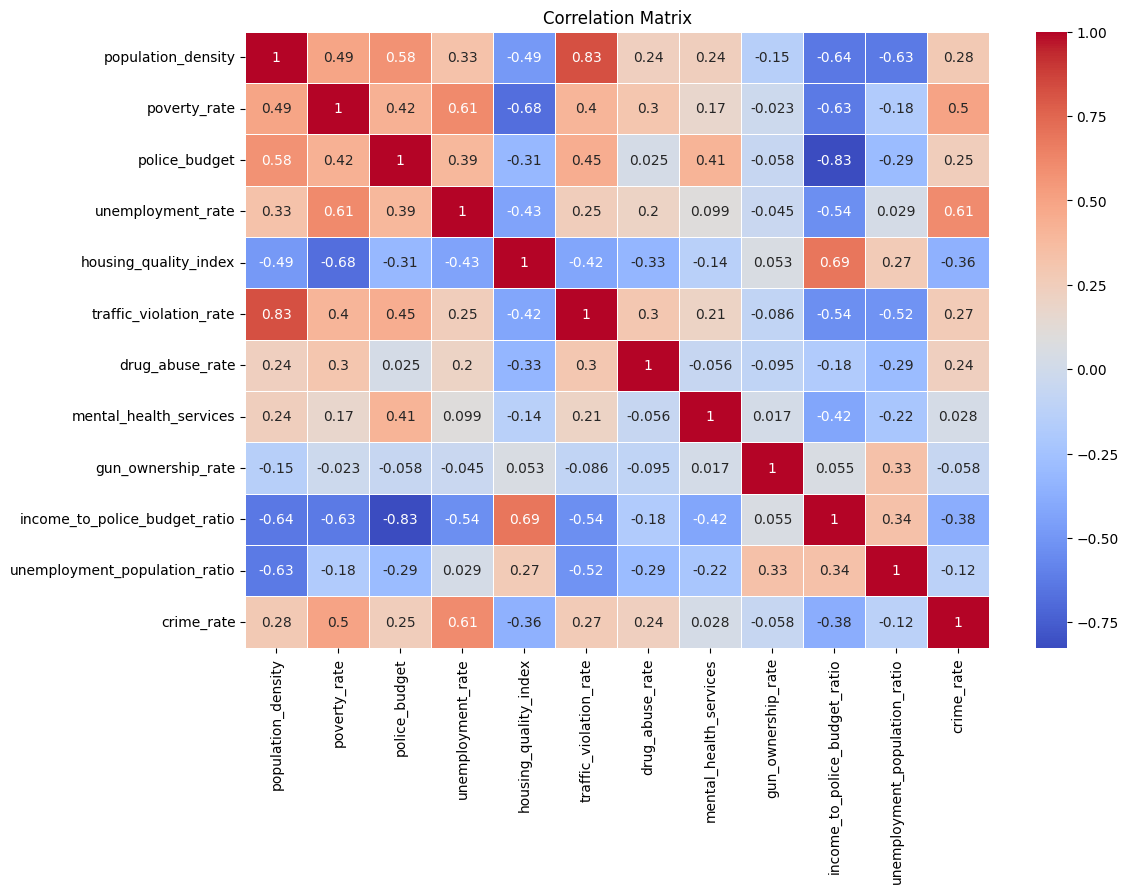

In [30]:
# Correlation matrix heatmap
features = ['population_density', 'poverty_rate', 'police_budget', 'unemployment_rate',
            'housing_quality_index', 'traffic_violation_rate', 'drug_abuse_rate',
            'mental_health_services', 'gun_ownership_rate',
            'income_to_police_budget_ratio', 'unemployment_population_ratio']

plt.figure(figsize=(12, 8))
correlation_matrix = crime_data[features + ['crime_rate']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error


# Split data into training and testing sets
features = ['population_density', 'poverty_rate', 'police_budget', 'unemployment_rate',
            'housing_quality_index', 'traffic_violation_rate', 'drug_abuse_rate',
            'mental_health_services', 'gun_ownership_rate',
            'income_to_police_budget_ratio', 'unemployment_population_ratio']
X = crime_data[features]
y = crime_data['crime_rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

# Evaluate the model
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Linear Regression - RMSE: {rmse:.2f}, R²: {r2:.2f}")

Linear Regression - RMSE: 11.13, R²: 0.25


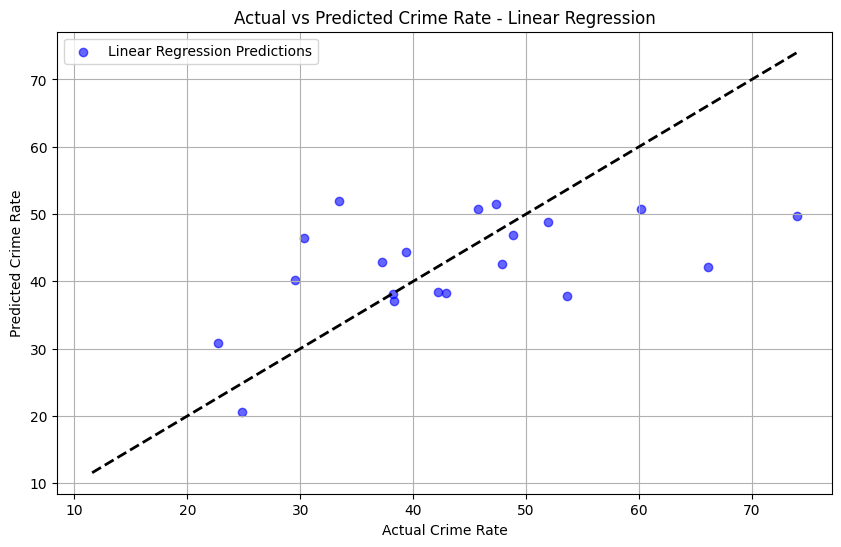

In [33]:
# Visualize actual vs predicted values for Linear Regression
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue', label='Linear Regression Predictions')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', linewidth=2)
plt.xlabel('Actual Crime Rate')
plt.ylabel('Predicted Crime Rate')
plt.title('Actual vs Predicted Crime Rate - Linear Regression')
plt.legend()
plt.grid(True)
plt.show()

#Task 3: Feature Importance using Decision Tree

                          feature  importance
3               unemployment_rate    0.419587
1                    poverty_rate    0.175076
2                   police_budget    0.073607
9   income_to_police_budget_ratio    0.070685
4           housing_quality_index    0.067306
6                 drug_abuse_rate    0.062341
10  unemployment_population_ratio    0.050227
8              gun_ownership_rate    0.035282
5          traffic_violation_rate    0.018867
0              population_density    0.016466
7          mental_health_services    0.010555


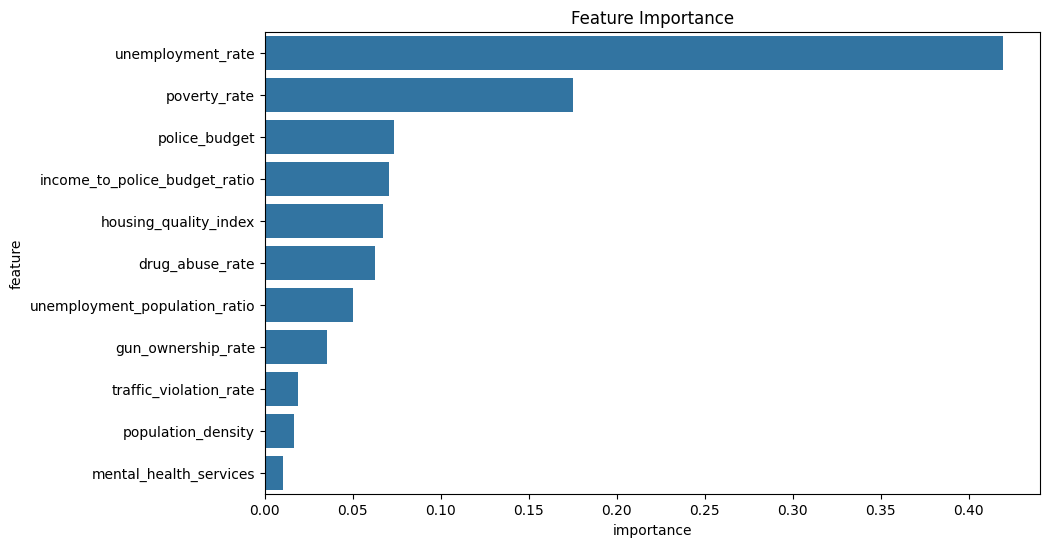

In [24]:
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import seaborn as sns


# Train a Decision Tree Regressor
tree_model = DecisionTreeRegressor()
tree_model.fit(X_train, y_train)

# Feature importance analysis
importances = tree_model.feature_importances_
feature_importance = pd.DataFrame({'feature': features, 'importance': importances})
feature_importance.sort_values(by='importance', ascending=False, inplace=True)
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance')
plt.show()


<ipython-input-31-8c393ea410fe>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=rf_feature_importance, palette='viridis')


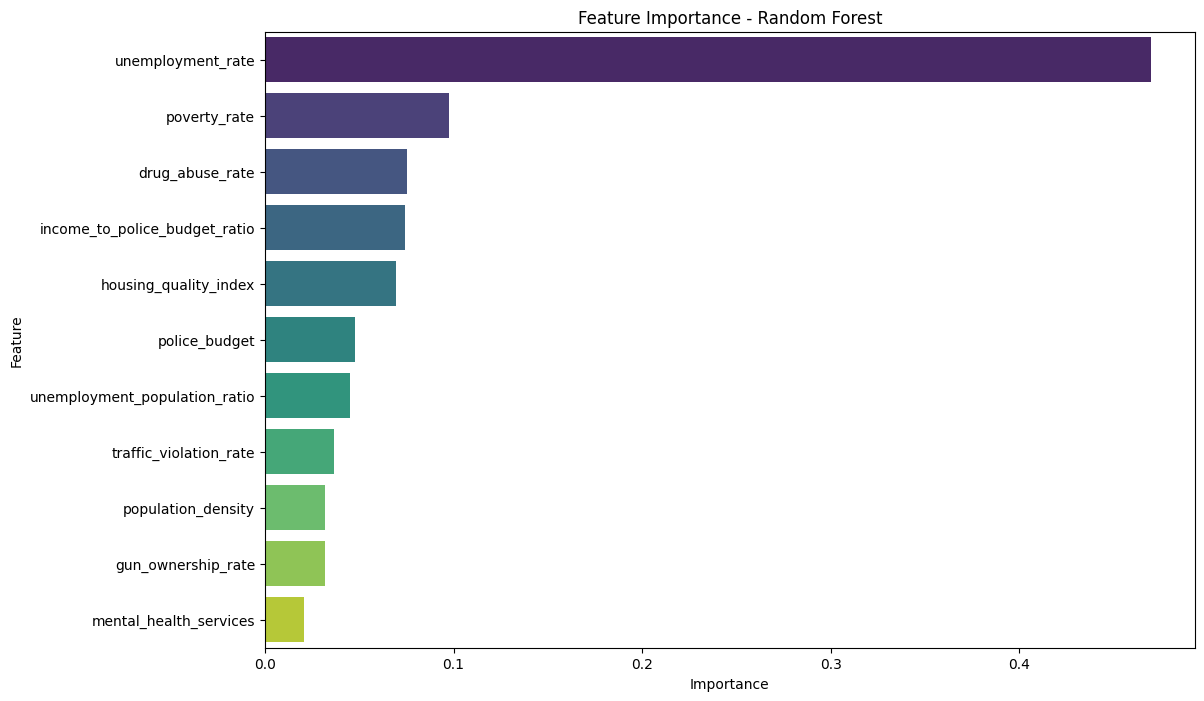

In [31]:
# Feature importance using Random Forest
rf_importances = rf_model.feature_importances_
rf_feature_importance = pd.DataFrame({'feature': features, 'importance': rf_importances})
rf_feature_importance.sort_values(by='importance', ascending=False, inplace=True)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=rf_feature_importance, palette='viridis')
plt.title('Feature Importance - Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Task 4: Hyperparameter Tuning with Random Forest

In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score

# Hyperparameter tuning with RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# Evaluate the model
rf_rmse = root_mean_squared_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)
print(f"Random Forest - RMSE: {rf_rmse:.2f}, R²: {rf_r2:.2f}")

Random Forest - RMSE: 10.38, R²: 0.35



# Task 5: Scenario Analysis ("What-If" Analysis)

In [29]:
# Increase police budget by 10% and observe changes
crime_data['police_budget'] = crime_data['police_budget'] * 1.1
X_new = crime_data[features]
new_predictions = rf_model.predict(X_new)

# Calculate average change in predicted crime rate
avg_change = (new_predictions - crime_data['crime_rate']).mean()
print(f"Average change in crime rate after increasing police budget by 10%: {avg_change:.2f}")

Average change in crime rate after increasing police budget by 10%: -0.29


<ipython-input-32-4e6990555566>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scenario_df['change_in_crime_rate'] = scenario_df['new_crime_rate'] - scenario_df['crime_rate']
<ipython-input-32-4e6990555566>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='city_name', y='change_in_crime_rate', data=scenario_sample, palette='coolwarm')


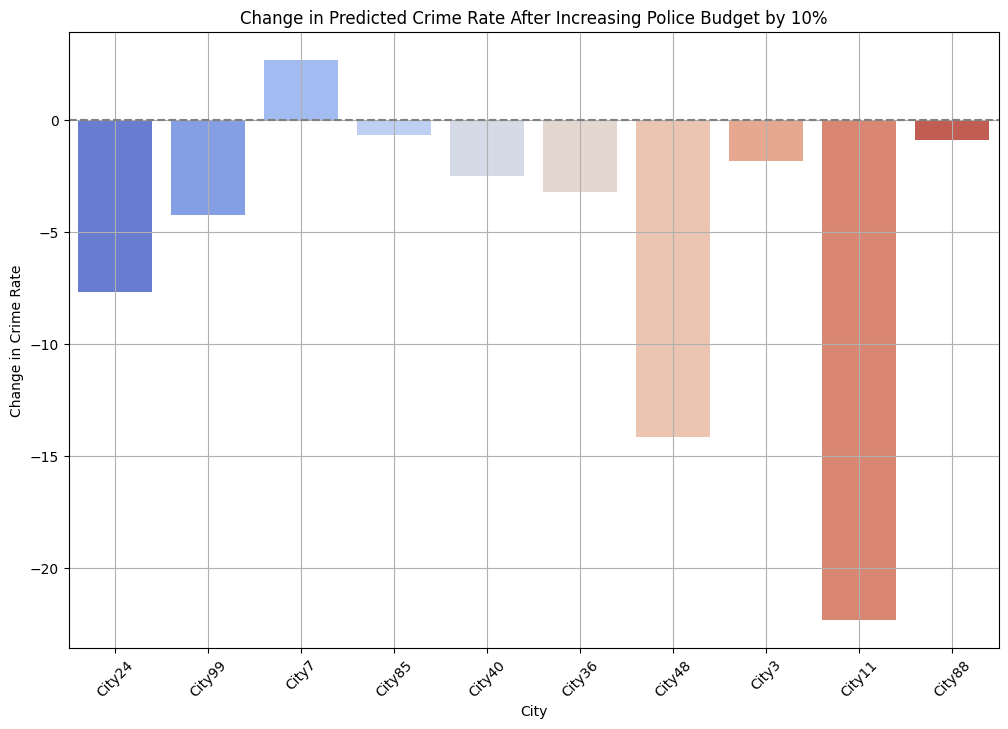

In [32]:
# Visualizing the effect of increasing police budget by 10%
crime_data['new_crime_rate'] = new_predictions
scenario_df = crime_data[['city_name', 'crime_rate', 'new_crime_rate']]
scenario_df['change_in_crime_rate'] = scenario_df['new_crime_rate'] - scenario_df['crime_rate']

# Plot the change in crime rate for a subset of cities
plt.figure(figsize=(12, 8))
scenario_sample = scenario_df.sample(10)  # Select a sample of 10 cities for visualization
sns.barplot(x='city_name', y='change_in_crime_rate', data=scenario_sample, palette='coolwarm')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Change in Predicted Crime Rate After Increasing Police Budget by 10%')
plt.xlabel('City')
plt.ylabel('Change in Crime Rate')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
